# Data Scientist Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

## Getting Started

In this project, we employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. Our goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries. The dataset as well some helper functions are provided by Udacity through [this repository](https://github.com/udacity/cd0025-supervised-learning/tree/master/starter).

----
## Exploring the Data

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display some values
display(data.tail())

age      workclass education_level  education-num       marital-status  \
45217   33        Private       Bachelors           13.0        Never-married   
45218   39        Private       Bachelors           13.0             Divorced   
45219   38        Private       Bachelors           13.0   Married-civ-spouse   
45220   44        Private       Bachelors           13.0             Divorced   
45221   35   Self-emp-inc       Bachelors           13.0   Married-civ-spouse   

             occupation    relationship                 race      sex  \
45217    Prof-specialty       Own-child                White     Male   
45218    Prof-specialty   Not-in-family                White   Female   
45219    Prof-specialty         Husband                White     Male   
45220      Adm-clerical       Own-child   Asian-Pac-Islander     Male   
45221   Exec-managerial         Husband                White     Male   

       capital-gain  capital-loss  hours-per-week  native-country income  
45217           0.0           0.0            40.0   United-States  <=50K  
45218           0.0           0.0            36.0   United-States  <=50K  
45219           0.0           0.0            50.0   United-States  <=50K  
45220        5455.0           0.0            40.0   United-States  <=50K  
45221           0.0           0.0            60.0   United-States   >50K

### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, we will compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [2]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data.income == '>50K'])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data.income == '<=50K'])

# Percentage of individuals whose income is more than $50,000
greater_percent = round((n_greater_50k / n_records) * 100,2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


### Feature exploration
Let's display some information about the features, such as their values and data types

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


----
## Preparing the Data
Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Let's plot a histogram of these two features

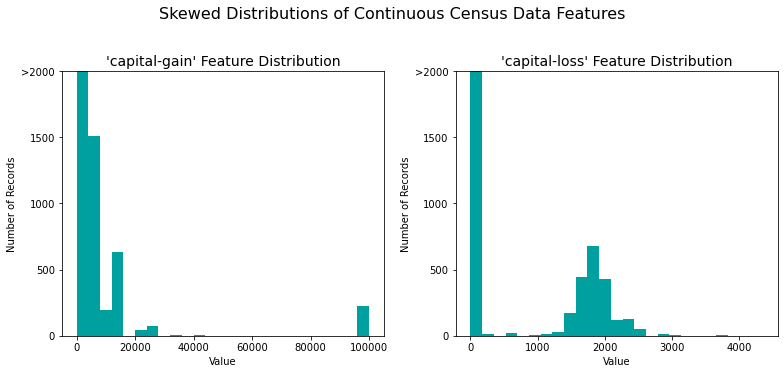

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

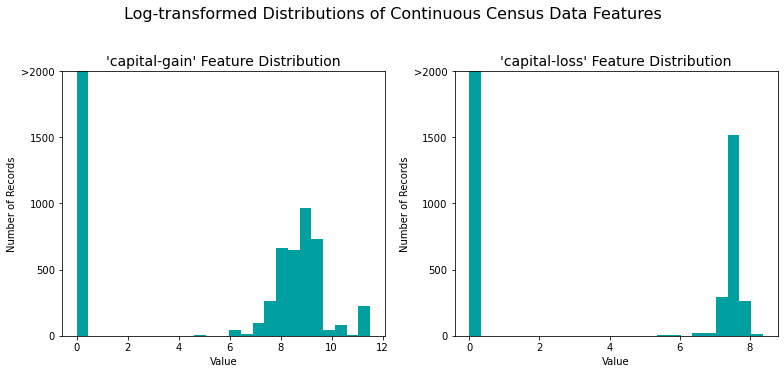

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

age          workclass education_level  education-num  \
0  0.301370          State-gov       Bachelors       0.800000   
1  0.452055   Self-emp-not-inc       Bachelors       0.800000   
2  0.287671            Private         HS-grad       0.533333   
3  0.493151            Private            11th       0.400000   
4  0.150685            Private       Bachelors       0.800000   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  
0      0.667492           0.0        0.397959   United-States  
1      0.000000           0.0        0.122449   United-States  
2      0.000000           0.0        0.397959   United-States  
3      0.000000           0.0        0.397959   United-States  
4      0.000000           0.0        0.397959            Cuba

### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively.

In [7]:
# One-hot encoding the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encoding the 'income_raw' data to numerical values, sklearns labelEncoder could also be used which is better for multiple labels
income_raw[income_raw == '>50K'] = 1
income_raw[income_raw == '<=50K'] = 0
income = income_raw.astype('int32')
# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
# print(encoded)

103 total features after one-hot encoding.


In [8]:
income.tail()

45217    0
45218    0
45219    0
45220    0
45221    1
Name: income, dtype: int32

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [9]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes, it is clear that most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? The the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally a base model would be either the results of a previous model or could be based on a research paper upon which we are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place we could start from.

In [10]:
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
# encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculating accuracy, precision and recall
accuracy = (TP+TN)/(TP + FP + TN + FN ) # all correctly classified points
recall = TP/(TP+FN)
precision = TP/(TP+FP)

# source: https://medium.com/@douglaspsteen/beyond-the-f-1-score-a-look-at-the-f-beta-score-3743ac2ef6e3
beta = 0.5
beta_square = beta**2 # done to save computation

fscore = (1 + beta_square) * (precision * recall) / ((beta_square * precision) + recall)

# Print the results 
print("Naive Predictor Performance: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor Performance: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models

### Model Application

<strong> Three models we can try and the reasons to consider them are explained below:
    
1. Naive Bayes
    - The algorithm is usually good for binary classification problems like [detecting spam e-mails](https://in.springboard.com/blog/email-spam-filtering-using-naive-bayes-classifier/)
    - As stated in [this article](https://towardsdatascience.com/all-about-naive-bayes-8e13cef044cf), it is computationally simple and it performs well in cases of categorical input variables compared to numerical variables
    - It relies heavily on the assumption that the input variables are indepedent which is often not the case, it is likely to perform poorely otherwise.The predicted class probabilities are not assumed to be accurate and should not be seriously considered in detail
    - We are dealing with a binary classification problem with many categorical input features so it is likely that Naive Bayes can have some skill

    
2. SVM
    - SVMs are traditionally considered a strong classification algorithm which is why they are the standard for many important real world problems like the [prediction of diabetes](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/1472-6947-10-16)
    - [This article](https://dhirajkumarblog.medium.com/top-4-advantages-and-disadvantages-of-support-vector-machine-or-svm-a3c06a2b107#:~:text=SVM%20algorithm%20is%20not%20suitable,samples%2C%20the%20SVM%20will%20underperform.) states that SVMs are memory efficient and perform well on high dimensional data
    - The same article states that SVM algorithm is not suitable for large data sets and there is no probablistic explenation of the classification proccedure
    - The data in this problem are high dimensional since we have a lot of input features, but the dataset is relatively small, so it is worth exploring SVMs

    
3. Random Forest
    - [This article](https://www.mygreatlearning.com/blog/random-forest-algorithm/#ApplicationsofRandomForest) states that banking and especially automated loan decision making for customers or fraud detection are some common applications of Random Forests 
    - In [this article](https://corporatefinanceinstitute.com/resources/knowledge/other/random-forest/) it is explained that random forest is a high performant algorithm that can handle large datasets with multiple features and can automatically handle missing values and imbalanced classes. Also the first article states that Random Forests work well both with numeric and categorical variables
    - The first article also emphsizes some potential drawbacks of random forests like potential delay in training and decision making due to the combination of several decision trees and the lack of interpretability as well as failing to determine the significance of each variable.
    - We have a dataset with many features and two imbalanced classes to predict. Also the dataset has both categorical and numeric features, so it is likely that Random Forest might have some advantages compared to other methods

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model we've chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Our implementation here will be used in the following section.
In the code block below, we will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.

In [11]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    from sklearn.metrics import fbeta_score, accuracy_score
    
    results = {}
    
    # Fit the learner to the training data using slicing
    start = time() # Get start time
    learner = learner.fit(X_train, y_train)
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation

36177 3617 361
GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.


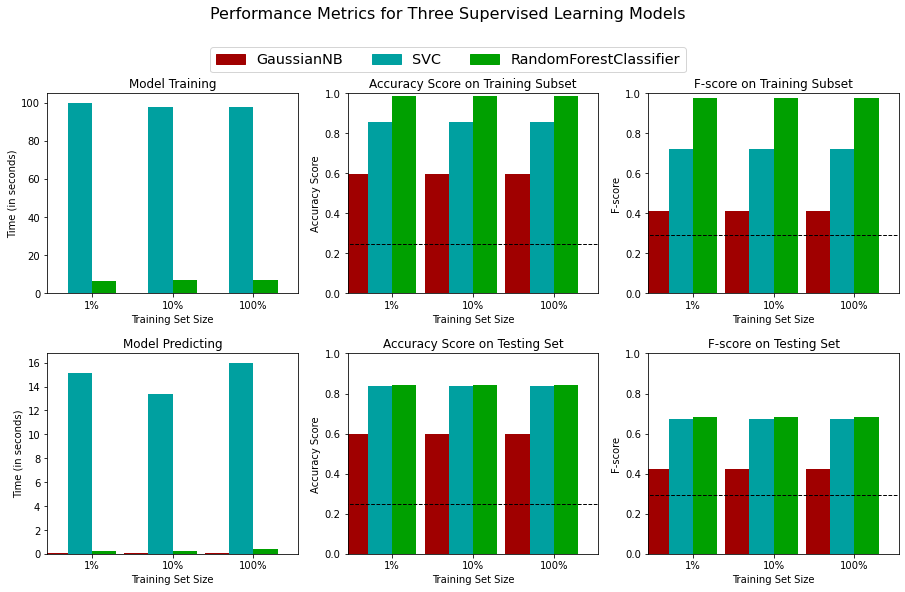

In [12]:
# Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Initialize the three models
clf_A = GaussianNB()
clf_B = SVC(gamma='auto', random_state=40)
clf_C = RandomForestClassifier(random_state=40)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(0.1*len(y_train))
samples_1 = int(0.01*len(y_train))
print(samples_100, samples_10, samples_1)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, we will choose from the three supervised learning models the *best* model to use on the student data. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Choosing the Best Model

**As expected, the Naive Bayes classifier is very fast but it does not achieve impressive results. On the other hand, the SVM and Random Forest classifiers achieve similar results on the test set with an accuracy close to 0.84 and an F-score close to 0.65 with Random forest slightly outperforming SVM. Also Random Forest trains approximately 7 times faster and infers approximately 12 times faster, so for the above reasons it is the best model out of these three**

### Describing the Model in Layman's Terms

**The model's logic is asking several questions in order to infer a conclusion. The model will begin by asking questions related to the most important attributes (features) by which a conclusion can be made, and then continuously move towards less important questions. The model is capable of doing this distinction because it includes feature selection in it's training stage. After asking all possible questions, the model has gained an "answer path" that it can use to infer the final class (Whether someone is predicted to earn more than 50000 or not). This path-matching capability is learnt by the model during the training phase, where it is continuously exposed to different answer paths for lots of times and it is also provided with the correct class that goes with this path. Taking advantage of this information the model is capable of learning the most important features (questions to ask first), as well as the answer (prediction) to all possible paths.** 

### Implementation: Model Tuning

In [13]:
#Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer, accuracy_score

# Initialize the classifier
clf = RandomForestClassifier(random_state=40)

# Create the parameters list we wish to tune, using a dictionary
# idea from: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 3)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2]
# Method of selecting samples for training each tree
# bootstrap = [True, False]

parameters = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator = clf, param_grid = parameters, verbose=2, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   5.3s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   4.7s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   4.5s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   5.6s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   5.5s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=1100 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=1100, total=  26.9s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=1100 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=1100, total=  25.4s
[CV] max_depth=10, min_samples_leaf=2, min_sampl

[CV]  max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   7.5s
[CV] max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1100 
[CV]  max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1100, total=  39.5s
[CV] max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1100 
[CV]  max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1100, total=  39.1s
[CV] max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1100 
[CV]  max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1100, total=  39.1s
[CV] max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1100 
[CV]  max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1100, total=  38.9s
[CV] max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1100 
[CV]  max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1100, total=  39.2s
[CV] max_depth=None,

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 35.8min finished


Unoptimized model
------
Accuracy score on testing data: 0.8427
F-score on testing data: 0.6816

Optimized Model
------
Final accuracy score on the testing data: 0.8610
Final F-score on the testing data: 0.7316


### Final Model Evaluation

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.8427            |   0.8610        |
| F-score        | 0.6816            |   0.7316        |


**We can see that by performing grid search we have managed to slightly improve the model in terms of accuracy but more importantly, to significantly improve the model in terms of F-score, which is the metric we are interested more in since we have unbalanced data. Both the unoptimized as well as the optimized model shows significant skill compared to the naive model that only achieved an F-score of 0.3972**

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

### Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data, we can intuitively select five of them as the most important ones

<strong> A logical thought would be to consider the features as below in terms of importance:

1. occupation, someone's job coould be the most important feature to how much he earns 
2. working hours per week, could be directly assoocited to someone's income
3. age, is also an important factor, intuitively we would expect older people to have larger income
4. capital gain, since people that pay lots of taxes will have less income
5. education level, could also be associated to someone's income so it is important 

</strong>

### Implementation - Extracting Feature Importance
We can also use some machine learning algorithms that can extract feature importance to visualize this information, an example is again the Random Forest classifier

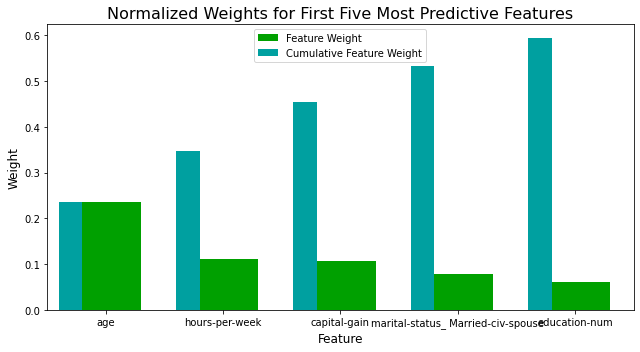

In [16]:
# Import a supervised learning model that has 'feature_importances_'
# recursive feature elimination could also be used here: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
from sklearn.ensemble import RandomForestClassifier

# Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Extracting Feature Importance

**We can see that we initially guessed three out of five features included. Age and hours per week rank high as we expected but occupation seems to not be that relevant. We were also right about capital gain which is relevant even though it is not in the top two relevant features. Regarding education instead of the education level that we expected, education-num appears more relevant, which could make sense if it corresponds to the total number of degrees a person holds or something relevant to this. The feature we missed is marital status, but it does make sense to affect someone's income, since married people often pay less taxes or work more to provide for their family.**

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below uses the same optimized model we found earlier, and trains it on the same training set *with only the top five important features*. 

In [17]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8610
F-score on testing data: 0.7316

Final Model trained on reduced data
------
Accuracy on testing data: 0.8449
F-score on testing data: 0.6912


### Effects of Feature Selection

**The model's  performance is slightly reduced on the reduced feature dataset and it is close to that of the unoptimized model. If training time was an important factor perhaps it would be of use to go with this dataset and perform another grid search to find a new optimized model**